In [1]:
from datasets import load_dataset
import pandas as pd
from rouge import Rouge
from openai import OpenAI
import json
from settings import *
from utils import preprocess, prompts, scores, utils
import os 

from langchain.llms import OpenAI, HuggingFaceHub
# from langchain import HuggingFaceHub
from langchain.chains import LLMChain 
from langchain.prompts import load_prompt, PromptTemplate
from tqdm import tqdm

from langchain.prompts import PromptTemplate
from langchain import LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, GenerationConfig
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
import warnings
warnings.filterwarnings("ignore")
import argparse 
import torch
import numpy as np                                                              
config = utils.load_json(CONFIG_DIR)
np.random.seed(2024)
from langchain.text_splitter import CharacterTextSplitter

/home/kis/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain_core.prompts.string import get_template_variables

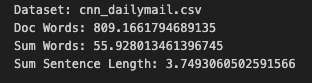

In [3]:
# df = utils.load_data("ccdv/pubmed-summarization", lower = 0, upper = 30000)
# df.head(3)

In [4]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
cache_dir = "../Youtube-Short-Generator/models/mistral"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,cache_dir=cache_dir)
tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    cache_dir=cache_dir)
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    max_new_tokens= 450,
    device = 0, 
    pad_token_id=tokenizer.eos_token_id)
hf = HuggingFacePipeline(pipeline=pipe)

Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


In [19]:
def map_prompt():
    template="""
    <s>[INST]<>Find the entertaining moment in this script and return it.

    Document: {document}<>[/INST]<\s>.
    """
    return template

def reduce_prompt():
    template = """
    <s>[INST]<>Please pick out the top five scenes that could be the most entertaining moments or 'hot clips' from various parts of the script.
    Entertaining Moments: {ext_sum}<>[/INST]<\s>.
    """
    return template


In [21]:
def create_map_reduce_chain():
    map_template = PromptTemplate(
        template=prompts.prompt_extsum_paper2(),
        input_variables=["document"]
        )
    map_chain = LLMChain(llm=hf, prompt=map_template)

    reduce_template = PromptTemplate(
        template= reduce_prompt(),
        input_variables=["ext_sum"]
        )
    reduce_chain = LLMChain(llm=hf, prompt=reduce_template) 

    # reduce_chain에 전달할 문서 정의. 여러 문서를 하나로 결합하는 역할
    combine_documents_chain = StuffDocumentsChain(
        llm_chain=reduce_chain, 
        document_variable_name= "ext_sum" # (reduce_template 에 정의된 변수명)
    )
    # token_max를 넘어가면 문서를 결합하거나 분할하는 역할
    reduce_documents_chain = ReduceDocumentsChain(
        # map_chain들의 결과를 결합
        combine_documents_chain=combine_documents_chain,
        # max_token이 넘어가면 분할
        collapse_documents_chain=combine_documents_chain,
        # The maximum number of tokens to group documents into.
        token_max=2000,
    )

    # 문서들에 체인을 매핑하여 결합하고, 그 다음 결과들을 결합
    map_reduce_chain = MapReduceDocumentsChain(
        # Map chain
        llm_chain=map_chain,
        # Reduce chain
        reduce_documents_chain=reduce_documents_chain,
        document_variable_name="document", # (map_template 에 정의된 변수명)
        # Return the results of the map steps in the output
        return_intermediate_steps=False,
    )
    return map_reduce_chain

In [8]:
# def create_map_reduce_chain():
#     map_template = PromptTemplate(
#         template=prompts.prompt_extsum_paper2(),
#         input_variables=["document"]
#         )
#     map_chain = LLMChain(llm=hf, prompt=map_template)

#     reduce_template = PromptTemplate(
#         template=prompts.prompt_combine_template(),
#         input_variables=["document"]
#         )
#     reduce_chain = LLMChain(llm=hf, prompt=reduce_template) 

#     # reduce_chain에 전달할 문서 정의. 여러 문서를 하나로 결합하는 역할
#     combine_documents_chain = StuffDocumentsChain(
#         llm_chain=reduce_chain, 
#         document_variable_name="document"
#     )
#     # token_max를 넘어가면 문서를 결합하거나 분할하는 역할
#     reduce_documents_chain = ReduceDocumentsChain(
#         # map_chain들의 결과를 결합
#         combine_documents_chain=combine_documents_chain,
#         # max_token이 넘어가면 분할
#         collapse_documents_chain=combine_documents_chain,
#         # The maximum number of tokens to group documents into.
#         token_max=2000,
#     )

#     # 문서들에 체인을 매핑하여 결합하고, 그 다음 결과들을 결합
#     map_reduce_chain = MapReduceDocumentsChain(
#         # Map chain
#         llm_chain=map_chain,
#         # Reduce chain
#         reduce_documents_chain=reduce_documents_chain,
#         # The variable name in the llm_chain to put the documents in
#         document_variable_name="document",
#         # Return the results of the map steps in the output
#         return_intermediate_steps=False,
#     )
#     return map_reduce_chain

In [9]:
# sample_df = df.sample(2)
# for idx, row in sample_df.iterrows():
#     print(len(row['document']))

In [10]:
# torch.cuda.empty_cache()
# text_splitter = CharacterTextSplitter(
#     separator= '\n',
#     chunk_size = 1000,
#     chunk_overlap = 100,
#     length_function = len,
# )
# result = []
# chain = create_map_reduce_chain()
# for i in tqdm(range(len(sample_df)), total = len(sample_df)):
#     # 문서 split
#     split_docs = text_splitter.create_documents([df.iloc[i,0]])
#     # map reduce 과정 수행
#     summarize_text = chain.run(split_docs)
#     torch.cuda.empty_cache()
#     result.append(summarize_text)

In [22]:
text = """
(00:00) My friend Mac is about to experience the scariest moment of his life. I'm just going to let you know I'm not afraid of anything. - We'll see. - You cannot scare me. Seal him up. You have to survive 10 minutes with a thousand spiders to move on. Release the spiders. Start the timer. The reason we're doing this is because Mack said no matter how hard I tried, I can't scare him.
(00:26) Would you say you're scared now? Getting there a little bit. - A little bit? - Yeah. And this is only one of many fears Mack will face in this video. Oh, good. And if he can successfully face all of the fears, he will win $800,000. I'm not going to lie, this was way more gnarly than I thought it would be.
(00:43) Three, two, one. Lift it up. Lift it up. Oh yeah. Congratulations on passing the first challenge. Let's go. But Mack has to finish all of these fears if he wants to win the $800,000 prize. Mack, I know you're blindfolded, but trust me. Just walk up this ramp. Raise us up. Why are you taking a knee? W
(01:06) hat is...? Stand up. Stand up. You're fine. You're fine. No, no, no, no. All right, Jimmy. Okay, you can hold on to it. That's cute. Oh my God! Okay. Mack, take off your blindfold. Welcome to challenge number two. The next fear is the fear of heights. You're going to stand on the end of that plank, unclip this so you'll be connected to nothing.
(01:29) Nah, dude. Press that button and then freefall 200 feet, and without knowing how, trust, I'll catch you. No! No! You're shaking. Yeah, of course I'm shaking. I'm going to fall off of this without a harness on. - Yeah. - I can't even see the ground. Be very careful. Mack, I'm just going to tell you, even though you can't see the ground, you are very, very high.
(01:50) Oh, my God, Mack. All you have to do is unclip it and press that button. Oh my... I want you to look at me in the eyes right now and tell me that I'm going to fall and something's going to catch me. Something will break your fall. I promise. Oh my... You're literally attached to nothing. Oh, my God.
(02:09) - The clip is gone. - Oh, my God. You don't have to do it. If you want to, you can tap out and just admit that you are wrong and you do get scared. No way. God, dude. I would have to say you look pretty scared. Oh, my God. Five, four, three, two... one. Godspeed. Godspeed. Zero. Let's go! I can't believe you did it.
(03:00) He's a psycho. And if you're wondering who my psychotic friend Mack is he's actually a contestant from a previous challenge video. And sadly, he ended up losing $800,000. But now he is on challenge three of six to attempt to win that money back. Here we are. - Yeah. - The next challenge. What'd you get? A $5 car and put $800,000 inside of it? As you can see, this car is pointed towards a lake.
(03:25) I'm guessing you're going to want me to drive the car into the lake? No. That would be dangerous. As you can see, there's no gas pedal. Obviously, you can't drive it in the lake. Yeah, I'm so stupid. Why would I think that I can drive it into the lake? - Yeah. Yeah. - Stupid. Yeah. Which is why we're going to drop him in the lake.
(03:40) Bring in the crane! Jimmy, Jimmy, Jimmy, Jimmy, Jimmy. It is getting real now. Okay. Oh, my God. Oh, my God. All right, Mack, listen up and listen good. Once we drop you at this lake, the car will quickly begin to sink. And in the back seat is the 800 grand you've been competing for divvied up into eight duffel bags.
(04:01) However many bags you can save from this sinking car determines how much money you'll continue competing for in this video. And whatever you leave behind is gone forever. Oh my gosh, dude. I will never tell you that I'm scared, but I'm about as close as you can be right now to that feeling. I can tell.
(04:18) Before we drop your car, I'm going to give you a one offer. If you quit right now and admit I scared you, I'll give you $100,000. And we call it even. Yeah. All right. He's not going to take it. - There's not a gosh darn chance. - I knew that was going... Hey, Nolan, take that. I knew he was going to do this.
(04:35) I lost it all last time. It's not happening again. Three! Two! One! Oh, my God. Drop him! Hey Mack! You've got about 20 seconds to break out of that car before it sinks under the water. Mack, the car is going under. Hurry up. Oh, God. That car is gone. That sunk so fast. Oh, my God. He's out. He's alive.
(05:34) Hey Mack! Nolan, go grab that bag from him. Somebody grab this. The scariest part about this challenge is every second the car sinks deeper into the water, making it harder to get to and harder to see. So if Mack wants to keep all of the prize money. He really needs to be moving as fast as possible. But as you can see, that's not going to be easy.
(06:07) Nolan, come here. Take it. Mack continued saving bag. Oh my God. After bag, after bag. Mack, you're crazy. But on top of the fact that the car is sinking deeper and deeper. What Mack hasn't realized yet is that the last two bags of money are actually seatbelted into the back seat of the car. Dude, Mack could be in an action movie, honestly.
(06:45) Well, he was like a borderline Olympic swimmer earlier in his life, which is why I did this fear. Yeah, but it's like 40 feet down and the water is freezing cold. How can you hold your breath out? He got another bag. Well, you got $700,000 on the boat. Just stop now. Just stop now. Just leave it on the bottom of lake.
(07:07) - We can do the next. - No. All right. He doesn't care. At this point, the car was literally at the bottom of this 45 foot deep lake, making it almost impossible for Mack to retrieve the last $100,000. Yeah you know, I really cannot. It's black down there. There's nothing. Are you officially calling it? I can't see the car, Jimmy. It's gone, yes.
(07:27) The boat's tilting. You are very athletic. Do you like this video better or the other video better? Dude, this video is like 10 times as intense. I know. And even though this looks very crazy, there's actually seven safety divers on standby to make sure Mack didn't die. Your prize is now 700 grand, but from here on out, it's all or nothing.
(07:46) Mack has to face the three remaining fears to walk out of this with his 700 grand. - This one might be the hardest one. - Okay Is it grosser than spiders? Just come on in. Inside this room is a metal box. In order to progress, you'll need to reach inside the box and pull out what's inside. And before you put your hand in the box, we're going to need you to sign this.
(08:04) It just basically says that you can't sue me if anything in there hurts you. Just sign right there. All right, we got it signed. What is it, like an animal or something? There are things in this box. Just step up here. You put your hand in one of these holes. Okay. And there's a thing in here you need to pull out.
(08:23) Dude, that is freaky as... Okay. I'm just going to make sure it's moving. - Stop. - Okay, go for it. Clearly it has not touched him yet. No matter what, once you grab onto it, you have to pull it out. What you grabbed is our brand new Feastable bars. We got all new branding and a better tasting formula.
(08:49) - Let's try it together. - I am not going to go soft on you. I'm going to tell you honestly what I think. Okay, that's pretty good. The new formula is milkier, creamier. We have our all new crunch flavor, the milk chocolate flavor, almond flavor, my personal favorite, and peanut butter. These new and improved Feastables bars are rolling out now.
(09:06) Give us a couple of days to get them on the shelves of your local Walmart, Target, 7-Eleven. And I cannot wait to see what you think of them. All right, Mack, you ready for the next fear? Jimmy, I've been in this exact same room, and I've had a bunch of money on the line before. Yeah. I'll tell you what.
(09:19) If you give me 500 grand right now, I'll walk. Do you guys hear this man? - Jimmy. - Who asked for $500,000? - 400 grand? - No. Hear me out. If you said 200, maybe 250, I would have considered it. - How about 350? - No. All right, let's go. Next challenge. I knew he'd break. All right, I might've lied.
(09:38) That one wasn't actually that hard. But this next one is actually based on one of the scariest things I've ever done. There's no way. How about quickly he pieced it together? Oh, no, no, no, no, no. There's actually no way. - Come on. - There is actually no way, Jimmy. Is it that obvious what it is? What gave it away? The tombstone with your name? Oh, Jesus.
(09:56) For the next challenge, we are going to bury you alive for 24 hours. No way, dude. And you can get out whatever you want, but you don't know what time it is. And if you leave before the 24 hour mark, you'll lose everything. That's a good fear. Yes. For once, I'm on the other side. Yeah bro! Oh, my gosh.
(10:17) It might get a little cold. Nolan, don't mess it up, please. I'll try not to. This is from my nightmares, man. It feels wrong being on the other side, but also fun. What the... Oh, this is so freaky. The funny thing is that the timer hasn't even started yet because you aren't fully buried. It feels wrong saying this, but can you bury me faster? As you wish, Mack! Bring in the extra hand.
(10:42) Stop it, stop it, stop, stop, stop, stop. Let's officially start the timer. Looks like 24 hours just started and I'm already freaked, so this ain't going to be good. Mack, see that rope above your head? Can you pull it for me real quick? - Is this a trick? - No. Next time you pull that bell, we will dig you up.
(11:01) And if it does not say above 24 hours, you lose everything. I will burn your house down. And also the $700,000. Yeah, I was like everything? Everything. Sweet dreams Macketh! All right, don't throw the walkie talkie. Was it that predictable? I already know they threw it, and I'm not even up there. There's so much more fun to be on this side of it.
(11:21) And to make sure Mack doesn't die in his own grave. He's going to be wearing this wristband that directly tells us his heart rate and vitals. And no, it does not give him any way of knowing what time it is. Basically, I need to figure out how to keep track of the time. Here's my strategy. I could try to stay awake for 2 hours, sleep for 10 hours, and then I would be halfway done with the challenge and I could just do that twice and that would be good.
(11:44) With Mack's plan now in place, his first step was to pass the time for the next 2 hours. Well, it's no Feastable bar, but I guess that makes hunger stop. But it was pretty obvious he was quickly getting bored. Dude, you got to be honest, there’s not much going on inside this room. That's the whole point.
(12:02) And Mack being bored this early is a pretty telltale sign that he may not be too good at this because already within 45 minutes, Mack's idea of time was horrendously off. I think it's been about 2 hours. I'm going to try to get about 10 hours of sleep, which should put me at the halfway mark. Even though the pro to sleeping is that it'll help Mack past time faster.
(12:23) First night sleeping in the coffin. The con is it's very difficult for him to keep track of how long he's been buried, especially when he's not even able to stay asleep for more than 30 minutes at a time. I have no idea what time it is right now. I'm a little creeped out. Hopefully for the love of God it's been over 12 hours.
(12:42) I think that's where we're at. And because when I did the challenge, I was constantly woken up by my friends... Jimmy Jam. I thought I'd give Mack the same joyful experience. Wake up, Mack. Are you okay? Dude, you look like you just got hit by a truck. Kind of feels like I did just get hit by a truck.
(13:00) If I was to legitimately guess how many hours in I am, I think it's like... The longer Mack stayed in the coffin, the less he seemed to know what time it was. It might be hour 16. And because we like to build a lot of suspense on this channel for the remainder of this fear, you're not going to know how long he's been in there either.
(13:24) And even though Mack wanted to ensure that he was going to be there long enough, it was clear that claustrophobia was getting to him. Being in this coffin is scary. Like... That... And the longer I'm in here, the worse I feel. It's a crazy feeling. But eventually, when we saw Mack begin to grab that rope, we knew he was thinking about ringing that bell.
(13:45) That's the face of somebody that's about to ring this bell soon. There's no way it's been under 24 hours. God, I'm nervous. I've been in one of these videos before. And I lost everything. And the only reason I even am back here at all and got a second chance is actually because of you guys.
(14:01) Me screwing up that second chance all comes down to if I know for a fact it's been 24 hours. I really hope I'm not making a mistake right now. Mack. Buddy, pal, how you doing? Jimmy, I'm pretty nervous. I don't want to accidentally reveal the time, so no comment. Jimmy, I don't know how you do this for seven days, dude.
(14:23) I do not feel well in here. Yeah. Have you got to the point where you start to lose blood flow in your legs and you feel like your back is going to fall out of your body? Jimmy, I'm thinking about pulling this thing. No comment. Jimmy, I'll give you 50 bucks back if you tell me what time it is. No comment.
(14:39) All right, I got a comment for you. Just get a shovel ready, all right? Three. Oh, my gosh, he's about to do it. Two... This is it. One. Stop the timer. And now that Mack has made his decision. There was just one last thing I had to do. Do you mind if I tell them about Shopify while we unbury you? You have got to be kidding.
(15:02) Shopify is a platform that helps entrepreneurs get started down the path they want. Sometimes starting a business can be scary, like getting covered in spiders or being buried alive. I can tell you, you do not want to be buried alive. But Shopify is here to help. If I hadn't started my own business, I wouldn't have been able to go to all the crazy places like Antarctica and make videos like these for you guys.
(15:19) And just like billions of other people have done with Shopify. You can get started today on your business right now. Mack, you want to know how long you were in there? I have a feeling you're not going to tell me until you dig me up. You are correct. And one of the perks of owning my own business is I can do fun things like send one of my friends to the Superbowl.
(15:34) Mack, Karl and Nolan each have their very own football for sale, and whoever's football sells the most. I'm going to give you tickets to the Super Bowl and I'm going to bury the other one alive. All that matters is that you download the Shop app and vote from one of them by buying either Nolan's or Karl's football.
(15:48) And now that I can afford this video, let's see if Mack loses $700,000. - Hi! - Hi! Hey, Jimmy. There you go! Welcome to the outside world. Now that you are out of the coffin, let's see if you were in there for 24 hours. If the number I reveal is lower than 24 hours, then you lose $700,000. I feel like I'm going to throw up.
(16:09) Three... Two... One... 36 hours! That is what I am talking about. He scares me. Congratulations, Mack. This means that you are now just one challenge away from winning all this money. Let's go. You should probably go shower first. Yeah, I smell not great. So far in this video, Mack has shown me It is very difficult to scare him, but the final challenge of this video may just be Mack's worst fear ever.
(16:40) And that's because the final challenge of this video is a 1 to 1 recreation of the challenge he failed on last time. The last challenge. Hold this in front of your face. Don't look. - Hey, I'm not looking. - Don't look. - I'm not looking. - All right, keep your eyes closed. Don't open them.
(16:55) Don't open your eyes. Keep walking. Don't open them. Don't open them. All right, open them. No, no, no. I'm not doing that again. Come over here. No! Jimmy, I do not want to do this again. Stand here where the cameras can see you. - No! - Okay. The last challenge is the fear of failure. We recreated the set where he lost $800,000 in this video And like last time, the rules are extremely simple.
(17:23) There are four stages. Each has its own cookie with a shape on it. You have to cut out all the shapes without breaking a cookie. And if you do break a cookie, you lose $700,000. And for you specifically, it will have been the second time it's happened. This is from my nightmares, man. I do not want to be here again.
(17:39) Well, good. Because I have an offer for you. You can quit right now and walk away with this 300 grand or risk it for the biscuit. And if you finish this final challenge, win $700,000. This is actually like a very, very big decision. Yeah, because that's not quite enough, is it? It's less than half.
(17:58) But if you lose again, that is $1.5 million lost on this set. Are you sure? He's hitting it. Mac, I know this is hard, but you're going to have to make a decision here. Do you want to go home with $300,000 or do you want to risk it all for this final challenge? All right, fine. I'm doing it. All right. To be honest, I'm glad. I want you to win this whole thing.
(18:22) If you look at this iPad right here, this is exactly how long it took Mack to get through all four stages last time he did the challenge, 34 minutes and 54 seconds. So that's exactly how long I'm going to give you again. Starting now. Don't break the cookie while opening. There you go. Even though he's going quick right now, might not be in his best interest because if he accidentally snaps a cookie, he loses.
(18:51) 34 minutes. You did it that quick? Scan, scan, scan, scan. It's green. This is a much different deal than last time. So I'm going to take my sweet time cutting the circle out. Let's go. He is flying through this. Why is it so much harder to open? Probably because you're like freaking out. You want me to try? Open it.
(19:22) Okay. Hold my iPad. Okay. It's very hard to open. What are you guys doing? I don't want to be responsible for that. Be careful. Theoretically, Mack's strategy makes sense. Getting through the easier shapes fast to save all the time for umbrella, which he lost $800,000 off. You literally still have 32 minutes left.
(19:45) Yeah. Well, I'm going to need all 32 of those for umbrella. That is borderline impossible. - Move out. - I'm moving. Open it. Allow me. Clap, clap, clap, clap, clap. Let's go. Mack, stop breaking my set. Bro, you guys got to make these easier to open. There's just no need to rush. You're literally using no time.
(20:12) I mean, you might need to go slower on this one because it's a lot trickier. This one is pretty hard, not even close umbrella. Trying to get to the race before I start racing. God, this is so hard. Oh my gosh. Well, I don't need that anymore. Maybe it didn't break all the way through? Okay. He still had 29 minutes left.
(20:57) He did the first two in 4 minutes I don't know why I did this. Oh, my God. I did that twice? Here. Give me your hand. No. Jimmy, please. I don't want to leave yet. No, Jimmy. Nah, dude. I don't even know how to feel right now. Right here. Come on. I have, like, so much time. Yeah. I'm still just not sure why you were going so fast.
(21:28) The umbrella, I just know that umbrella takes forever. Yeah. Okay. Mack told me in this video that there was nothing that I could do to scare him. And after putting him through spiders, a sinking car, and more, I really did start to believe him. Godspeed. The only thing that ended up getting to Mack... was the fear of his own failure.
(21:53) Godspeed.

"""

In [12]:
print(len(text))

19697


In [23]:
torch.cuda.empty_cache()
text_splitter = CharacterTextSplitter(
    separator= '\n',
    chunk_size = 1000,
    chunk_overlap = 100,
    length_function = len,
)
chain = create_map_reduce_chain()
split_docs = text_splitter.create_documents([text])
# map reduce 과정 수행
summarize_text = chain.run(split_docs)

In [24]:
summarize_text

'1. Mack\'s encounter with a thousand spiders: This scene is already mentioned in the previous response as an entertaining moment, but it\'s worth highlighting again due to the intense fear and suspense it creates.\n    2. Mack\'s fear of heights challenge: Watching Mack face his fear of heights and stand unclipped on the end of a plank is an exhilarating moment. The high stakes and the thrill of seeing someone overcome their fear make this scene a must-watch.\n    3. Mack and the car in the lake: The fear and uncertainty of losing $800,000 and the potential danger of the situation make this scene an entertaining moment. The tension builds as Mack and his partner plan and execute their plan to drop the car into the lake.\n    4. Mack\'s self-imposed burial experiment: The suspense of not knowing how long Mack has been buried and the potential danger of the situation make this scene an intriguing moment. The audience is left wondering if Mack will be able to survive and escape.\n    5. 

In [15]:
# import re
# for i in range(len(result)):
#     text = re.sub('\n', '', result[i])
#     result[i] = text

In [16]:
# result_df = pd.DataFrame({'document': sample_df['document'], 'abstract': sample_df['summary'], 'generate': result})
# value = 0
# for idx, row in result_df.iterrows():
#     try:
#         value_dic = scores.get_Rouge_score(row['generate'], row['abstract'])
#         value += value_dic['rouge-l']['f']
#     except:
#         continue
# print(value / len(sample_df))

In [17]:
# for idx, row in result_df.iterrows():
#     gen = row['generate']
#     abs = row['abstract']
#     doc = row['document']
#     print(f'Generate \n{gen}')
#     print('*' * 10)
#     print(f"Abstract \n:{abs}")
#     print('*' * 10)
#     print(f'Document \n:{doc}')
#     print('-' * 10)

뉴스 영상에 대한 가정: 한 영상에 다양한 주제 존재.  <br> RefineDocumentsChain을 통해 영상 텍스트에서 주제를 분류할 수 있게 구두점과 같은 부호 추가, <br>그 부호를 기준으로 텍스트를 chunk로 나누어 map reduce 과정을 수행